# MNIST Digit Recognition via Pytorch

## Requirements

* Python 3.*
* pip
* python modules:
> * torch
> * torchvision 
> * pandas (for convenient reading `*.csv` file and transform data to numpy type)
> * matplotlib
> * livelossplot (for dynamic visualization of training of the model)

## Content of the file 'requirements.txt'

In [1]:
with open('./requirements.txt', 'r') as f:
    print(f.read())

torch
torchvision
pandas
matplotlib
livelossplot


In [ ]:
!pip install -r ./requirements.txt

In [3]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from time import time
from torchvision import datasets, transforms
from torch import nn, optim
from IPython.core.debugger import set_trace
import pandas as pd
from livelossplot import PlotLosses

## Custom MNISTDataset class for dataset from Kaggle for DataLoader

> [from tutorial here](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html)


In [4]:
class MNISTDataset(torch.utils.data.Dataset):
    """MNIST Dataset from Kaggle"""
    
    def __len__(self):
        return len(self.data)
    
    def __init__(self, csv_path, train = True, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            transform (callable, optional): Optional transform to be applied
                on a sample.
            train (boolean): specify is the dataset for training
            
            transfrom (torchvision.transfroms): a pytorch object transfrom data (for normalizing, to cast for tensor etc.) 
        """
        csv_file = pd.read_csv(csv_path)
        
        if train:
            train_labels = csv_file['label'].values
            train_images = (csv_file.iloc[:,1:].values).astype('float32')
            train_images = train_images.reshape(train_images.shape[0], 28, 28)
            self.data = train_images
            self.targets = train_labels
        else:
            test_images = (csv_file.iloc[:,:].values).astype('float32')
            test_images = test_images.reshape(test_images.shape[0], 28, 28)
            self.data = test_images
            self.targets = None
            
        self.train = train
        self.transform = transform        
            
    def __getitem__(self, index):
                                  
        img = self.data[index]
        if self.transform is not None:
            img = self.transform(img)
                
        if self.train:
            return img, int(self.targets[index])
        else:
            return img

## Training environment params

In [5]:
BATCH_SIZE = 64
INPUT_SIZE = 28 * 28
OUTPUT_SIZE = 10

## Get dataset as DataLoader within PyTorch context 

In [6]:
#normalize the tensor with a mean 0.5 and standard deviation 0.5
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = MNISTDataset('./MNIST/train.csv', train=True, transform=transform)
testset = MNISTDataset('./MNIST/test.csv', train=False, transform = transform)

train_size = int(0.8 * len(trainset))
test_size = len(trainset) - train_size
trainset, valset = torch.utils.data.random_split(trainset, [train_size, test_size])

#test_loader for a submission in Kaggle Leaderboard
train_loader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(valset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)

## Utilite functions

In [7]:
def show_images(images):
    images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return 

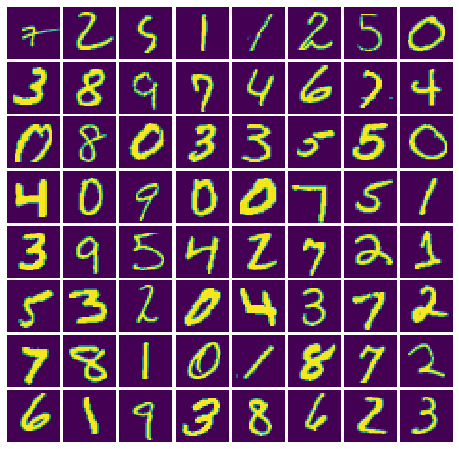

In [8]:
imgs = iter(train_loader).next()[0].view(BATCH_SIZE, 28 * 28).cpu().numpy().squeeze()
show_images(imgs)

## Neural network setting

In [9]:
#a layer for transition from convolutional layers to dense layers for linear classification(Conv->Flatten->Dense) 
class Flatten(nn.Module): 
    def forward(self, x):
        N, C, H, W = x.size() 
        return x.view(N, -1)

In [10]:
# xavier initialization of weights of our neural network  
def initialize_weights(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.xavier_uniform_(m.weight.data)

In [11]:
class MnistNet(nn.Module):
    def __init__(self):
        super(MnistNet, self).__init__()
        
        self.conv_block = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),
            nn.Dropout2d(p=0.25),
        )
        
        self.flatten = Flatten()
        
        self.linear_block = nn.Sequential(
            nn.Linear(64 * 14 * 14, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(128, 64), 
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(64, 10)
        )
        
    def forward(self, x):
        x = self.conv_block(x)
        x = self.flatten(x)
        x = self.linear_block(x)
        return x                

## Set up the configuration for the training of our neural netrwork

In [12]:
model = MnistNet()
model.apply(initialize_weights)
optimizer = optim.Adadelta(params=model.parameters(), rho=0.95)
criterion = nn.CrossEntropyLoss()

## Train model session

In [13]:
def train_model(model, criterion, optimizer, num_epochs=10):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    liveloss = PlotLosses()
    for epoch in range(num_epochs):
        logs = {}
        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
                data_loader = train_loader
            else:
                model.eval()
                data_loader = val_loader

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in data_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.detach() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(data_loader.dataset)
            epoch_acc = running_corrects.float() / len(data_loader.dataset)
            
            prefix = ''
            if phase == 'validation':
                prefix = 'val_'

            logs[prefix + 'log loss'] = epoch_loss.item()
            logs[prefix + 'accuracy'] = epoch_acc.item()
        
        liveloss.update(logs)
        liveloss.draw()


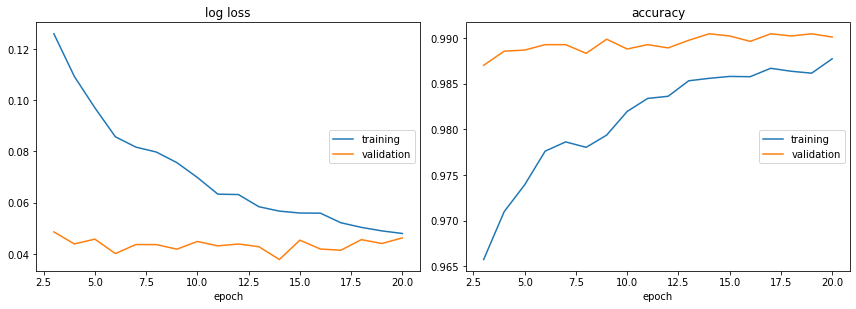

log loss:
training   (min:    0.048, max:    0.371, cur:    0.048)
validation (min:    0.038, max:    0.067, cur:    0.046)

accuracy:
training   (min:    0.892, max:    0.988, cur:    0.988)
validation (min:    0.980, max:    0.990, cur:    0.990)


In [14]:
train_model(model, criterion, optimizer, 20)

## Writing out a submission file for Kaggle Leaderbord

In [18]:
test_preds = torch.LongTensor()

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

model.eval()
for data in test_loader: 
    data = data.to(device)
    output = model(data)
    preds = output.cpu().data.max(1, keepdim=True)[1]
    test_preds = torch.cat((test_preds, preds), dim=0)

submission_df = pd.read_csv("./MNIST/sample_submission.csv")
submission_df['Label'] = test_preds.numpy().squeeze()
submission_df.head()
submission_df.to_csv('./MNIST/submission.csv', index=False)